# Applied Master Project - Portfolio Insurance: OBPI vs CPPI

### MSc Financial Engineering

Ugo ESCATO  
Aurore CLEVENOT  
Ludovic VINCENTI

## Librairies used

In [160]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.stats import norm, skew
from arch import arch_model

## Data and calibration

In [206]:
btc_data = yf.download('BTC-USD')
btc_daily = btc_data['Adj Close']
btc_weekly = btc_daily.resample('W').last()
btc_monthly = btc_daily.resample('ME').last()

[*********************100%***********************]  1 of 1 completed


In [192]:
btc_daily

Ticker,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-01-14,96534.046875
2025-01-15,100504.492188
2025-01-16,99756.906250


In [5]:
# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')

In [7]:
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('ME').last()

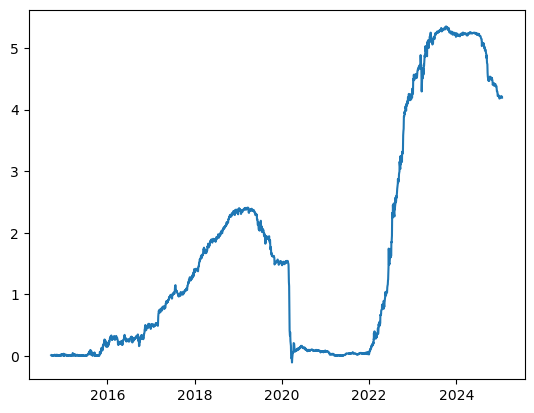

In [11]:
plt.plot(t_bill_daily)
plt.show()

## Parameters

In [52]:
initial_portfolio_value = 100000  
multipliers = [1, 2, 3, 4, 5, 6]  # Array of multipliers
floor_fractions = [0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Array of floor fractions

In [54]:
start_date = None
end_date = None

In [56]:
btc_weekly[start_date:end_date]

Ticker,BTC-USD
Date,
2014-09-21,398.821014
2014-09-28,377.181000
2014-10-05,320.510010
2014-10-12,378.549011
2014-10-19,389.545990
...,...
2024-12-22,95104.937500
2024-12-29,93530.226562
2025-01-05,98314.960938


In [58]:
btc_array = np.array(btc_weekly.loc[start_date:end_date])
t_bill_array = np.array(t_bill_weekly.loc[start_date:end_date])

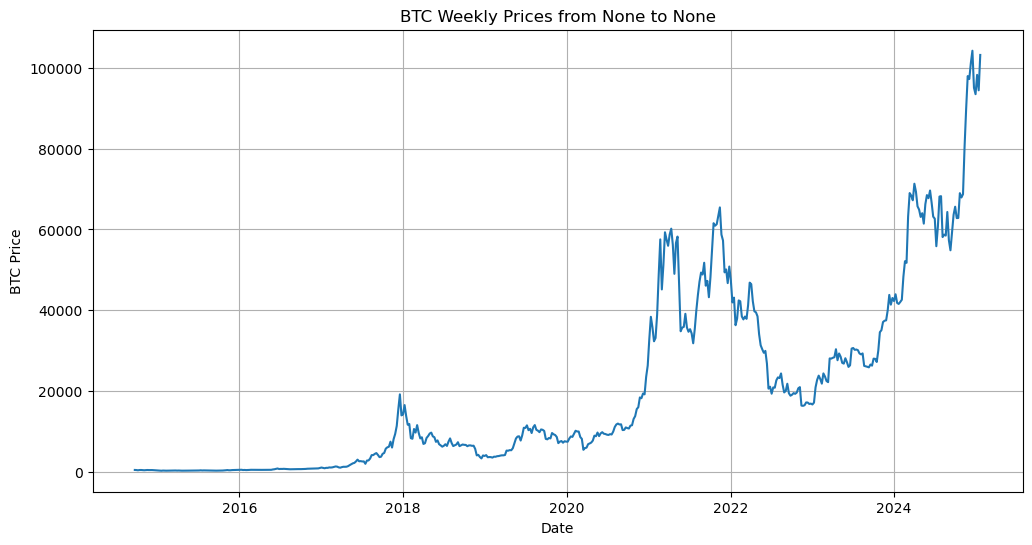

In [60]:
plt.figure(figsize=(12, 6))  # Adjust the size as needed
plt.plot(btc_weekly.loc[start_date:end_date])
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTC Weekly Prices from {} to {}'.format(start_date, end_date))
plt.grid(True)
plt.show()

## CPPI on historical prices of BTC

### CPPI no loop

In [401]:
def cppi_strategy(risky_asset, riskless_asset, multiplier, floor_fraction, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy.

    Parameters:
        risky_asset (array-like): Prices of the risky asset (e.g., BTC).
        riskless_asset (array-like): Prices of the risk-free asset (e.g., T-Bill).
        multiplier (float): Multiplier for the cushion.
        floor_fraction (float): Fraction of the initial portfolio value to set as the floor.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        pd.DataFrame: DataFrame containing basket values, risky weights, and risk-free weights.
    """
    # Convert inputs to NumPy arrays
    risky_asset = np.asarray(risky_asset)
    riskless_asset = np.asarray(riskless_asset)

    # Initialize variables
    basket_value = initial_portfolio_value
    floor = basket_value * floor_fraction
    risky_weights = []
    riskless_weights = []
    basket_values = []

    # Ensure both risky_asset and riskless_asset have the same length
    if len(risky_asset) != len(riskless_asset):
        raise ValueError("The lengths of risky_asset and riskless_asset must be the same.")

    # Assuming 'btc' DataFrame has a DateTime index or a 'Date' column
    dates = btc_weekly.loc[start_date:end_date].index  # If 'risky_asset' is a pandas Series/DataFrame with a DateTime index

    # Loop over each time step
    for i in range(1, len(risky_asset)):
        # Calculate the cushion as a percentage of the portfolio
        cushion = max(basket_value - floor, 0) / basket_value

        # Calculate the risky allocation based on the CPPI formula
        risky_w = multiplier * cushion
        risky_w = min(risky_w, 1)  # Cap the risky allocation to 100%
        risky_w = max(risky_w, 0)  # Ensure the risky allocation is non-negative

        # Calculate the risk-free allocation
        riskless_w = 1 - risky_w

        # Calculate returns
        risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
        riskless_return = ((1 + riskless_asset[i] / 100) ** (1 / 52)) - 1  # Adjust annualized return 

        # Update portfolio value
        portfolio_return = risky_w * risky_return + riskless_w * riskless_return
        basket_value = basket_value * (1 + portfolio_return)

        # Append the results
        risky_weights.append(risky_w)
        riskless_weights.append(riskless_w)
        basket_values.append(basket_value)

    # Convert results to a DataFrame and set the index to the dates of the risky asset
    cppi_df = pd.DataFrame({
        'Basket Value': basket_values,
        'Risky Weights': risky_weights,
        'Risk-Free Weights': riskless_weights
    }, index=dates[1:])  # Skip the first date since we start from index 1

    return cppi_df

In [218]:
# Calculate the CPPI strategy
cppi_results = cppi_strategy(btc_array, t_bill_array, multiplier, floor_fraction, initial_portfolio_value)

cppi_results

,Basket Value,Risky Weights,Risk-Free Weights
Date,,,
2014-09-28,[96744.44050559308],0.6,0.4
2014-10-05,[90664.48445057445],[0.4182839119444699],[0.5817160880555301]
2014-10-12,[91386.52990570801],[0.043974294097709046],[0.956025705902291]
2014-10-19,[91628.53503086539],[0.091032884636628],[0.908967115363372]
2014-10-26,[90754.6519505743],[0.10663938020946048],[0.8933606197905395]
...,...,...,...
2024-12-15,[276795.5914072098],1,0
2024-12-22,[252396.51696681645],1,0
2024-12-29,[248217.4326174413],1,0


In [277]:
plt.plot(cppi_results['Basket Value'])
plt.show()
cppi_results['Basket Value'].iloc[-1]

KeyError: 'Basket Value'

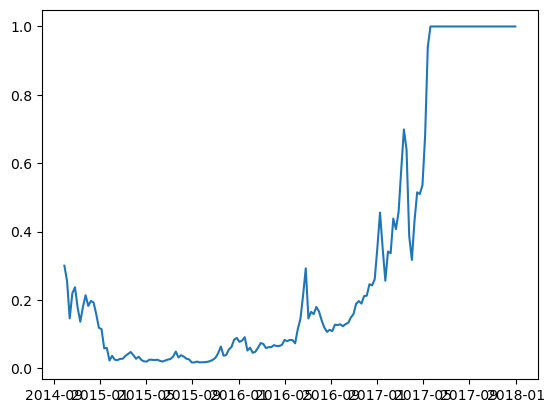

In [80]:
plt.plot(cppi_results['Risky Weights'])

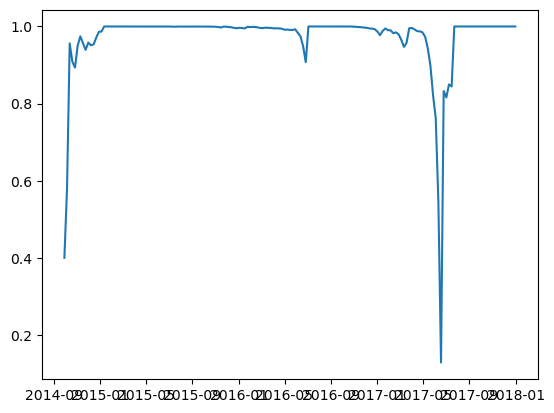

In [36]:
plt.plot(cppi_results['Risk-Free Weights'])

### CPPI with loop

In [62]:
def cppi_strategy_loop(risky_asset, riskless_asset, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple combinations
    of multiplier and floor_fraction values.

    Parameters:
        risky_asset (array-like): Prices of the risky asset (e.g., BTC).
        riskless_asset (array-like): Prices of the risk-free asset (e.g., T-Bill).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the initial portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing DataFrames for each (multiplier, floor_fraction) combination.
    """
    # Convert into arrays
    risky_asset = np.asarray(risky_asset)
    riskless_asset = np.asarray(riskless_asset)

    # Ensure same length
    if len(risky_asset) != len(riskless_asset):
        raise ValueError("The lengths of risky_asset and riskless_asset must be the same.")

    dates = btc_weekly.loc[start_date:end_date].index  # Adjust as per data 

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            
            basket_value = initial_portfolio_value
            floor = basket_value * floor_fraction
            risky_weights = []
            riskless_weights = []
            basket_values = []

            for i in range(1, len(risky_asset)):
                
                cushion = max(basket_value - floor, 0) / basket_value

                risky_w = multiplier * cushion
                risky_w = max(risky_w, 0)  # Ensure the risky allocation is non-negative

                # risk-free allocation
                riskless_w = 1 - risky_w

                # returns
                risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
                riskless_return = ((1 + riskless_asset[i] / 100) ** (1 / 52)) - 1  # Adjust as needed

                # Update portfolio value
                portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                basket_value = basket_value * (1 + portfolio_return)

                # Append the results
                risky_weights.append(risky_w)
                riskless_weights.append(riskless_w)
                basket_values.append(basket_value)

            # Convert results to a DataFrame and set the index to the dates of the risky asset
            cppi_df = pd.DataFrame({
                'Basket Value': basket_values,
                'Risky Weights': risky_weights,
                'Risk-Free Weights': riskless_weights
            }, index=dates[1:])  # Skip the first date since we start from index 1

            # Store the DataFrame in the results dictionary
            results[(multiplier, floor_fraction)] = cppi_df

    return results

In [72]:
# Run CPPI strategy for all combinations
cppi_results = cppi_strategy_loop(btc_array, t_bill_array, multipliers, floor_fractions, initial_portfolio_value)

# Access results for a specific combination
df = cppi_results[(4, 0.9)] # Multiplier=3, Floor Fraction=0.9
df

,Basket Value,Risky Weights,Risk-Free Weights
Date,,,
2014-09-28,[97829.65905422422],0.4,0.6
2014-10-05,[93124.19966091283],[0.3201343694711012],[0.6798656305288988]
2014-10-12,[95387.23838059469],[0.134194964242969],[0.865805035757031]
2014-10-19,[96013.53630985753],[0.22591023587870862],[0.7740897641212914]
2014-10-26,[93862.14182571958],[0.25052868755715785],[0.7494713124428422]
...,...,...,...
2024-12-22,[23077.710129223302],[0.0],[1.0]
2024-12-29,[23095.893820265817],[0.0],[1.0]
2025-01-05,[23114.135924862403],[0.0],[1.0]


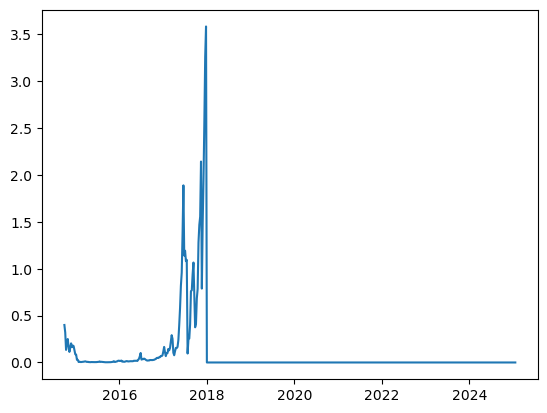

In [74]:
plt.plot(cppi_results[(4, 0.9)]['Risky Weights'])

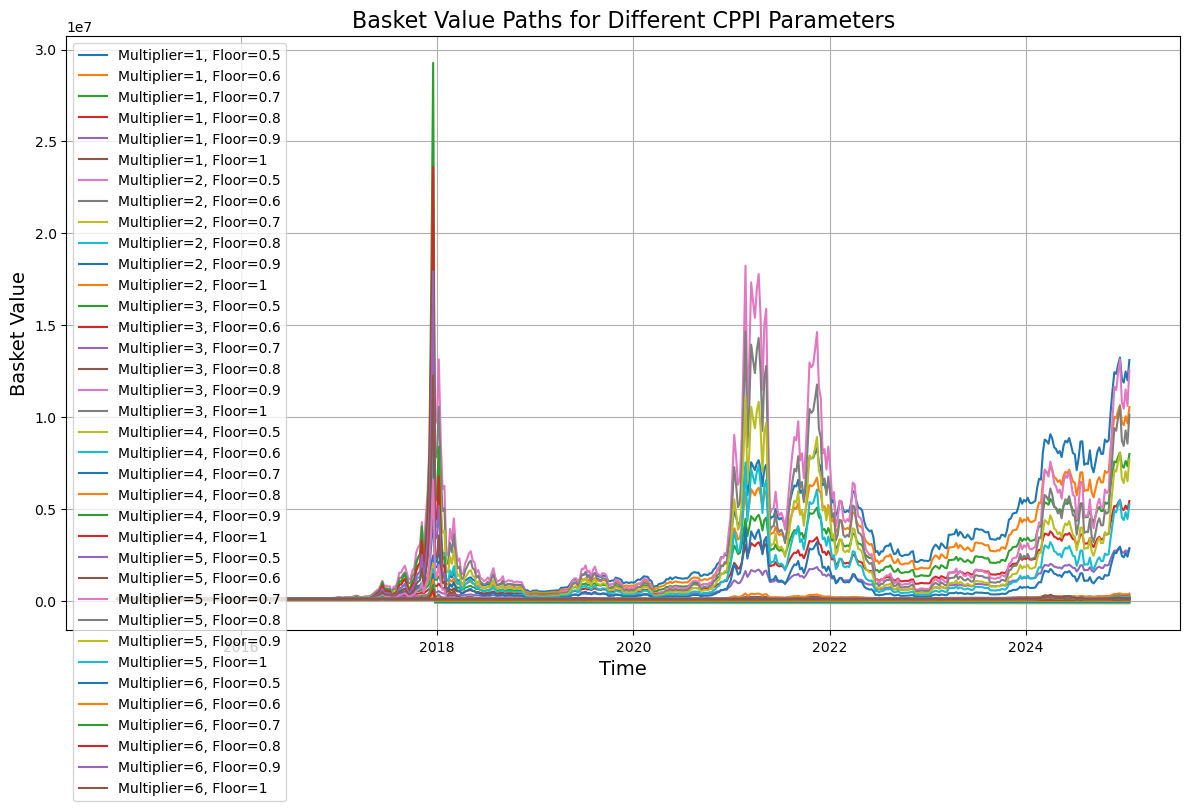

In [76]:
def plot_basket_values(results):
    """
    Plots all the basket value paths for different combinations of multiplier and floor_fraction.

    Parameters:
        results (dict): Dictionary containing DataFrames for each (multiplier, floor_fraction) combination.
    """
    plt.figure(figsize=(12, 8))
    
    for (multiplier, floor_fraction), df in results.items():
        plt.plot(df.index, df['Basket Value'], label=f'Multiplier={multiplier}, Floor={floor_fraction}')
    
    plt.title("Basket Value Paths for Different CPPI Parameters", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Basket Value", fontsize=14)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_basket_values(cppi_results)

In [78]:
max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best (multiplier, floor_fraction)

for (multiplier, floor_fraction), df in cppi_results.items():
    last_basket_value = df['Basket Value'].iloc[-1]
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (multiplier, floor_fraction)  # Update best parameters

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Multiplier = {best_params[0]}, Floor Fraction = {best_params[1]}")

Maximum Basket Value: [13099824.8517898]
Best Parameters: Multiplier = 1, Floor Fraction = 0.5


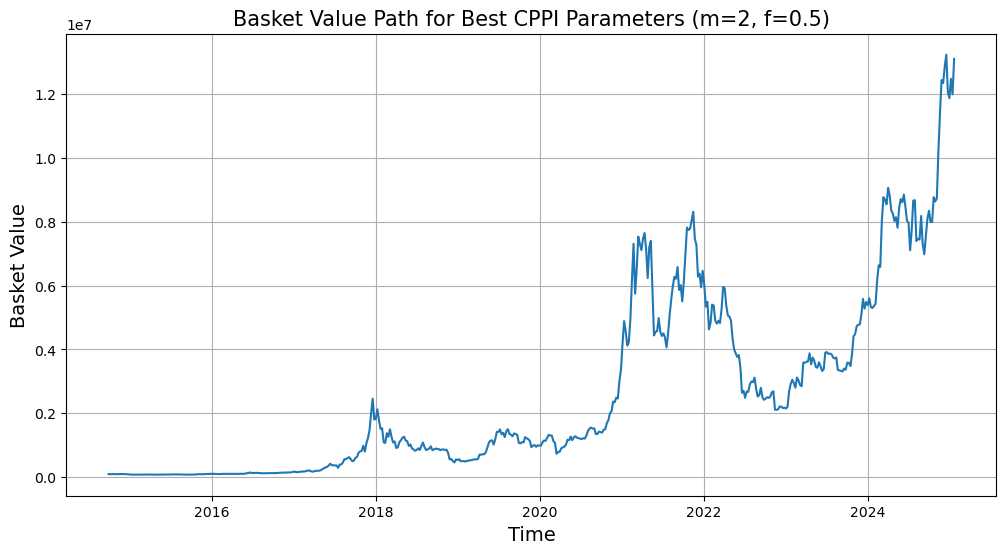

In [80]:
plt.figure(figsize=(12, 6))  # Adjust the size as needed
plt.plot(cppi_results[(1, 0.5)]['Basket Value'])
plt.title("Basket Value Path for Best CPPI Parameters (m=2, f=0.5)", fontsize=15)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Basket Value", fontsize=14)
plt.grid(True)
plt.show()

In [82]:
basket_values = pd.DataFrame(cppi_results[(1, 0.5)]['Basket Value'])
basket_values_ret = basket_values.pct_change().dropna().values
basket_values_ret.mean()

array([0.01295087])

In [84]:
risk_free_rate = t_bill_array / 100  # Weekly rate
risk_free_rate = risk_free_rate.flatten()
risk_free_rate = risk_free_rate[:len(basket_values_ret)].mean()

In [86]:
risk_free_rate

0.017074095403481

In [88]:
basket_values_ret_ann = basket_values_ret.mean() * 52
basket_values_ret_ann_std = basket_values_ret.std() * np.sqrt(52)
basket_values_ret_ann_sr = (basket_values_ret_ann - risk_free_rate) / basket_values_ret_ann_std

print(f'Avg return annualized: {basket_values_ret_ann}')
print(f'Std annualized: {basket_values_ret_ann_std}')
print(f'SR annualized: {basket_values_ret_ann_sr}')

Avg return annualized: [0.67344513]
Std annualized: [0.62972451]
SR annualized: [1.04231458]


In [171]:
data = cppi_results[(2, 0.5)]['Basket Value']

# Step 1: Calculate the mean
mean = data.mean()

# Step 2: Calculate squared differences from the mean
squared_differences = (data - mean) ** 2

# Step 3: Calculate the average of squared differences (variance)
variance = squared_differences.mean()  # Population variance

# Step 4: Take the square root to get the standard deviation
std_dev = np.sqrt(variance)

mean, std_dev


(array([290553.06021371]), array([519149.30302147]))

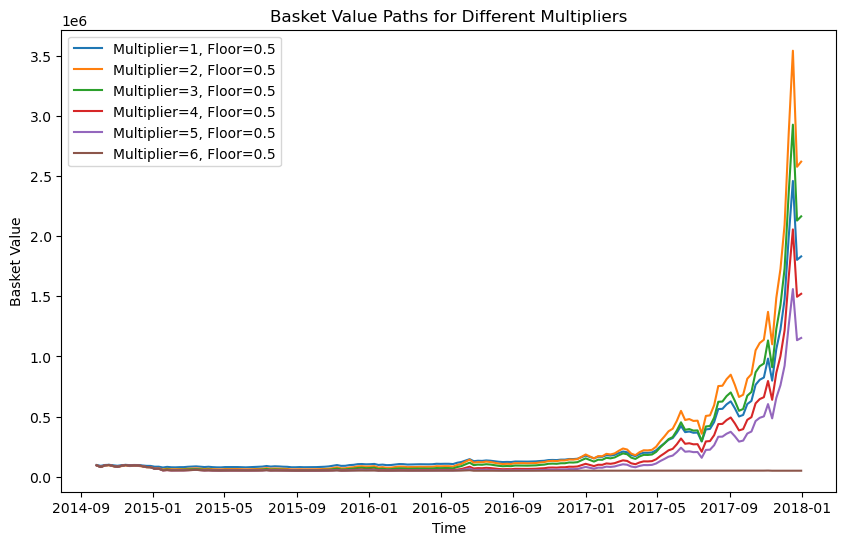

In [85]:
plotted_multipliers = set()  # To track already plotted multipliers
plt.figure(figsize=(10, 6))

for key, df in cppi_results.items():
    # Extract multiplier value
    multiplier = key[0] if isinstance(key, tuple) else key

    # Plot only if the multiplier hasn't been plotted yet
    if multiplier not in plotted_multipliers:
        plt.plot(df.index, df['Basket Value'], label=f'Multiplier={multiplier}, Floor={key[1]}')
        plotted_multipliers.add(multiplier)  # Mark this multiplier as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Different Multipliers')
plt.legend()
plt.show()

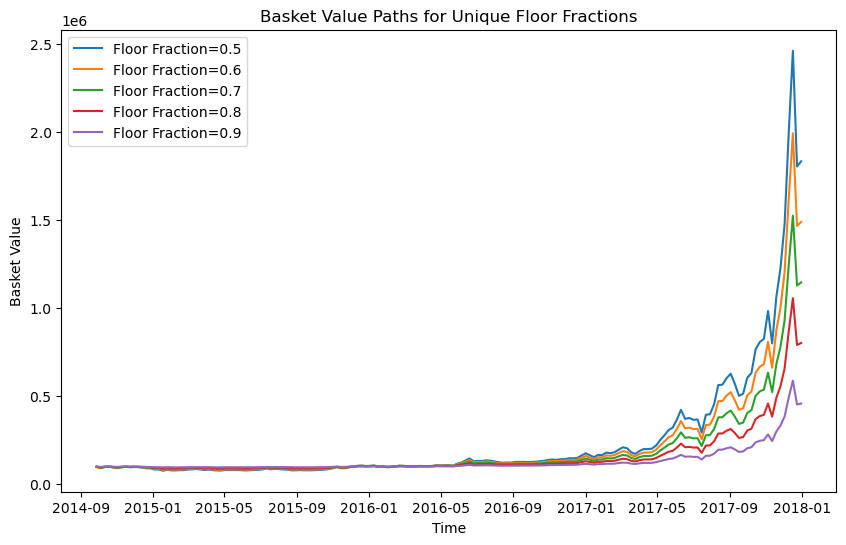

In [87]:
plotted_floors = set()  # To track already plotted floor fractions
plt.figure(figsize=(10, 6))

for key, df in cppi_results.items():
    # Extract floor fraction value
    floor_fraction = key[1] if isinstance(key, tuple) else key

    # Plot only if the floor fraction hasn't been plotted yet
    if floor_fraction not in plotted_floors:
        plt.plot(df.index, df['Basket Value'], label=f'Floor Fraction={floor_fraction}')
        plotted_floors.add(floor_fraction)  # Mark this floor fraction as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Unique Floor Fractions')
plt.legend()
plt.show()

## OBPI on historical prices of BTC

### OBPI without loop

In [453]:
def obpi_strategy(risky_asset, riskless_rate, floor_fraction, initial_portfolio_value, time_to_maturity):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy.

    Parameters:
        risky_asset (array-like): Prices of the risky asset (e.g., BTC).
        riskless_rate (array-like): Annualized risk-free rates (e.g., T-Bill rates in %), same length as risky_asset.
        floor_fraction (float): Fraction of the initial portfolio value to set as the floor.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.

    Returns:
        pd.DataFrame: DataFrame containing basket values, risky weights, and risk-free weights.
    """
    # Convert inputs to NumPy arrays
    risky_asset = np.asarray(risky_asset)
    riskless_rate = np.asarray(riskless_rate)
    
    # Ensure inputs have the same length
    if len(risky_asset) != len(riskless_rate):
        raise ValueError("The lengths of risky_asset and riskless_rate must be the same.")
    
    # Initialize variables
    basket_value = initial_portfolio_value
    floor = basket_value * floor_fraction
    dt = 1 / 52  # Weekly time step in years
    time_steps = len(risky_asset) - 1

    # Initialize lists to store results
    risky_weights = []
    riskless_weights = []
    basket_values = []

    # Assuming 'risky_asset' has a DateTime index
    dates = risky_asset.index if isinstance(risky_asset, pd.Series) else None

    # Loop over each time step
    for i in range(1, len(risky_asset)):
        # Update remaining time to maturity
        remaining_ttm = time_to_maturity - i * dt

        # Update risk-free allocation to ensure the floor is met
        riskless_allocation = floor / ((1 + riskless_rate[i] / 100) ** remaining_ttm)
        risky_allocation = max(basket_value - riskless_allocation, 0)

        # Calculate risky and risk-free weights
        risky_w = risky_allocation / basket_value
        riskless_w = 1 - risky_w

        # Ensure weights are valid
        risky_w = max(min(risky_w, 1), 0)
        riskless_w = 1 - risky_w

        # Calculate returns
        risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
        riskless_return = ((1 + riskless_rate[i] / 100) ** (1 / 52)) - 1  # Weekly compounding

        # Update portfolio value
        portfolio_return = risky_w * risky_return + riskless_w * riskless_return
        basket_value = basket_value * (1 + portfolio_return)

        # Append results
        risky_weights.append(risky_w)
        riskless_weights.append(riskless_w)
        basket_values.append(basket_value)

    # Convert results to a DataFrame and set the index to the dates of the risky asset
    obpi_df = pd.DataFrame({
        'Basket Value': basket_values,
        'Risky Weights': risky_weights,
        'Risk-Free Weights': riskless_weights
    }, index=dates[1:] if dates is not None else range(1, len(risky_asset)))

    return obpi_df

In [455]:
floor_fraction = 0.9  
initial_portfolio_value = 100000  
time_to_maturity = len(btc_array)/52  # in years

# Run OBPI strategy
obpi_results = obpi_strategy(btc_array, t_bill_array, floor_fraction, initial_portfolio_value, time_to_maturity)

# Display results
obpi_results

,Basket Value,Risky Weights,Risk-Free Weights
1,[99697.47121144633],[0.16770571984991228],[0.8322942801500877]
2,[98851.65250660416],[0.16548001511946156],[0.8345199848805385]
3,[96073.73327129695],[0.15893770058661869],[0.8410622994133813]
4,[96786.24928818167],[0.134114758248268],[0.865885241751732]
5,[97062.34103850731],[0.13820499197099143],[0.8617950080290085]
...,...,...,...
267,[246340.00093079446],[0.6290691785421065],[0.37093082145789347]
268,[232604.99092493302],[0.6358097439823195],[0.3641902560176805]
269,[230311.02205011228],[0.6139911163276249],[0.38600888367237507]
270,[237567.16395407694],[0.6098406584237718],[0.3901593415762282]


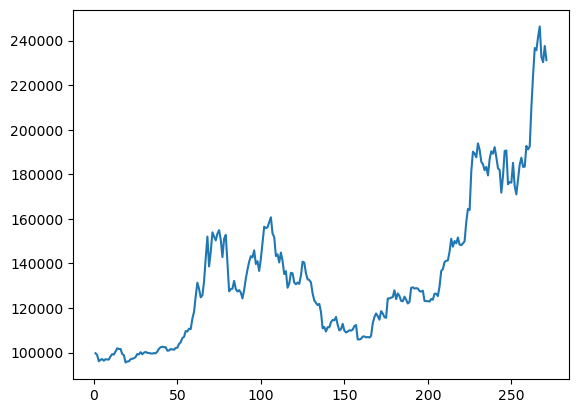

array([231247.69814882])

In [457]:
plt.plot(obpi_results['Basket Value'])
plt.show()
obpi_results['Basket Value'].iloc[-1]

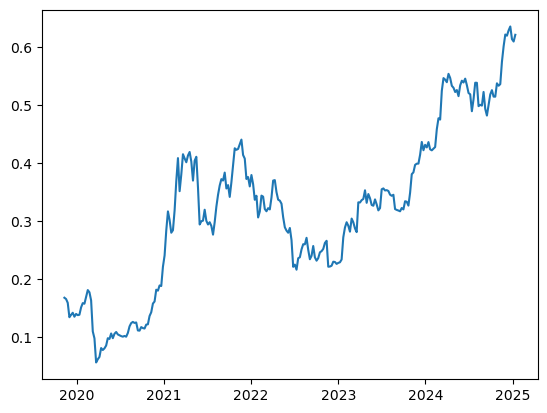

In [373]:
plt.plot(obpi_results['Risky Weights'])
plt.show()

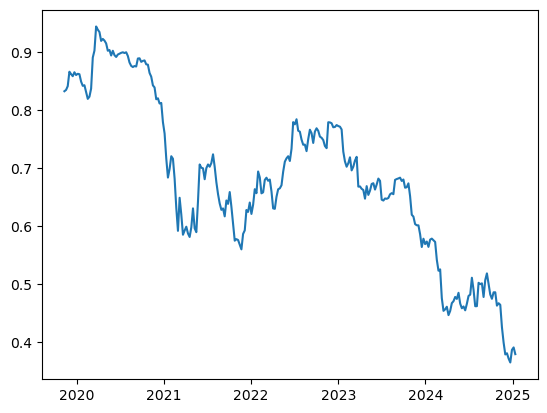

In [375]:
plt.plot(obpi_results['Risk-Free Weights'])
plt.show()

### OBPI with loop

In [98]:
def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price and delta of a European put option.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        r (float): Risk-free rate (annualized).
        sigma (float): Volatility of the stock (annualized).

    Returns:
        float: Price of the put option.
        float: Delta of the put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    put_delta = -norm.cdf(-d1)

    return put_price, put_delta

In [126]:
def obpi_strategy_loop(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (array-like or pd.Series): Prices of the risky asset (e.g., BTC).
        riskless_rate (array-like or pd.Series): Annualized risk-free rates (e.g., T-Bill rates in %), same length as risky_asset.
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float): Volatility of the risky asset (annualized).

    Returns:
        dict: Dictionary containing DataFrames for each floor_fraction.
    """
    
    def black_scholes_put(S, K, T, r, sigma):

        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)

        return put_price, put_delta

    # Convert inputs to NumPy arrays if they are not pandas Series
    if isinstance(risky_asset, pd.Series):
        dates = risky_asset.index
        risky_asset = risky_asset.values
    else:
        dates = None

    if isinstance(riskless_rate, pd.Series):
        riskless_rate = riskless_rate.values

    # Ensure inputs have the same length
    if len(risky_asset) != len(riskless_rate):
        raise ValueError("The lengths of risky_asset and riskless_rate must be the same.")

    results = {}
    dt = 1 / 52  # Weekly time step in years

    for floor_fraction in floor_fractions:
        # Initialize variables
        basket_value = initial_portfolio_value
        floor = basket_value * floor_fraction

        # Initialize lists to store results
        risky_weights = []
        riskless_weights = []
        basket_values = []

        # Loop over each time step
        for i in range(1, len(risky_asset)):
            # Update remaining time to maturity
            remaining_ttm = time_to_maturity - i * dt

            # Calculate put option price and delta
            put_price, put_delta = black_scholes_put(risky_asset[i], floor, remaining_ttm, riskless_rate[i] / 100, sigma)

            # Update weights based on OBPI formula
            risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)

            # Ensure weights are within bounds
            risky_w = max(0, min(1, risky_w))
            riskless_w = 1 - risky_w

            # Calculate returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
            riskless_return = ((1 + riskless_rate[i] / 100) ** (1 / 52)) - 1  # Weekly compounding

            # Update portfolio value
            portfolio_return = risky_w * risky_return + riskless_w * riskless_return
            basket_value = basket_value * (1 + portfolio_return)

            # Append results
            risky_weights.append(risky_w)
            riskless_weights.append(riskless_w)
            basket_values.append(basket_value)

        # Create the output DataFrame
        index = dates[1:] if dates is not None else range(1, len(risky_asset))
        obpi_df = pd.DataFrame({
            'Basket Value': basket_values,
            'Risky Weights': risky_weights,
            'Risk-Free Weights': riskless_weights
        }, index=index)

        results[floor_fraction] = obpi_df

    return results

In [128]:
time_to_maturity = len(btc_array)/52  # year

# Assuming 'risky_asset' and 'riskless_rate' are pandas Series
obpi_results = obpi_strategy_loop(btc_array, t_bill_array, floor_fractions, initial_portfolio_value, time_to_maturity, 0.2)

In [130]:
obpi_results[0.9]

,Basket Value,Risky Weights,Risk-Free Weights
1,[100000.09615148646],[4.6552457163539745e-19],[1.0]
2,[100000.28844992952],0,1
3,[100000.38460169332],[4.672121011355703e-19],[1.0]
4,[100000.78199883955],[9.631226861107477e-19],[1.0]
5,[100000.87815107791],0,1
...,...,...,...
535,[154186.43671877644],[0.833375651311798],[0.16662434868820197]
536,[152230.97694964823],[0.7765894758144284],[0.2234105241855716]
537,[159801.48289812068],[0.971674032967061],[0.028325967032938992]
538,[154204.6465870964],[0.9018675634826736],[0.0981324365173264]


In [132]:
len(btc_array)

540

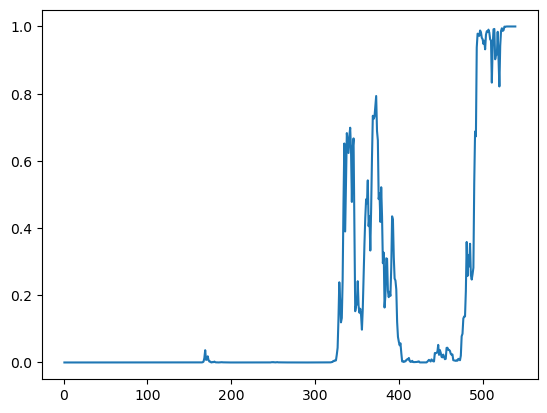

In [138]:
plt.plot(obpi_results[0.5]['Risky Weights'])
plt.show()

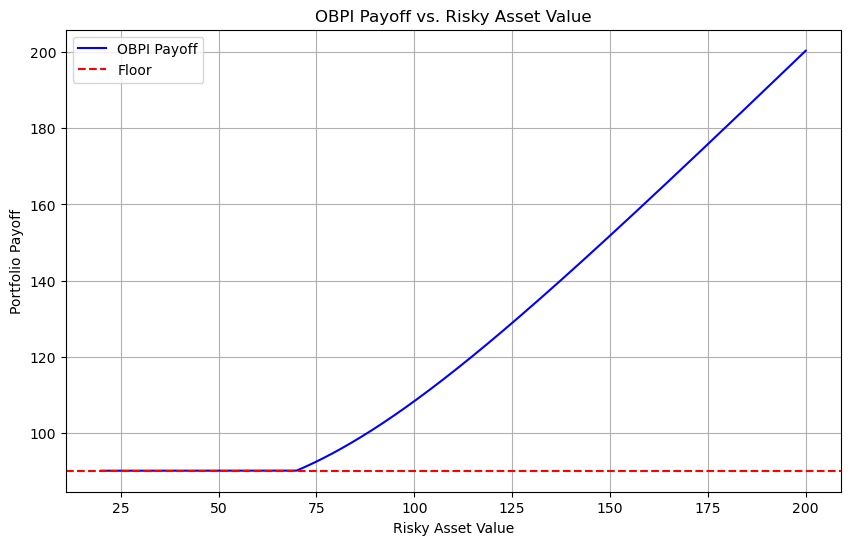

In [158]:
def calculate_payoff(risky_asset_values, floor, initial_portfolio_value, sigma, riskless_rate, time_to_maturity):
    """
    Calculate the payoff of the OBPI product as a function of the risky asset value.
    
    Parameters:
        risky_asset_values (array-like): Range of risky asset values.
        floor (float): Floor value of the portfolio.
        initial_portfolio_value (float): Initial portfolio value.
        sigma (float): Volatility of the risky asset (annualized).
        riskless_rate (float): Risk-free rate (annualized, in decimal form).
        time_to_maturity (float): Time to maturity in years.
    
    Returns:
        np.array: Payoff values for the given risky asset values.
    """
    payoffs = []
    for risky_value in risky_asset_values:
        # Calculate the put option price using Black-Scholes formula
        put_price, _ = black_scholes_put(
            risky_value, floor, time_to_maturity, riskless_rate, sigma
        )
        # Portfolio payoff is the sum of the risky asset value and the put price
        payoff = max(risky_value + put_price, floor)
        payoffs.append(payoff)
    return np.array(payoffs)

# Parameters
risky_asset_values = np.linspace(20, 200, 10000)  # Example range of risky asset prices
initial_portfolio_value = 100
floor_fraction = 0.9
floor = initial_portfolio_value * floor_fraction
sigma = 0.25  # Annualized volatility
riskless_rate = 0.03  # Annualized risk-free rate in decimal form
time_to_maturity = 3  # Time to maturity in years

# Calculate the payoffs
payoffs = calculate_payoff(risky_asset_values, floor, initial_portfolio_value, sigma, riskless_rate, time_to_maturity)

# Plot the payoff
plt.figure(figsize=(10, 6))
plt.plot(risky_asset_values, payoffs, label="OBPI Payoff", color="blue")
plt.axhline(floor, color="red", linestyle="--", label="Floor")
plt.title("OBPI Payoff vs. Risky Asset Value")
plt.xlabel("Risky Asset Value")
plt.ylabel("Portfolio Payoff")
plt.legend()
plt.grid()
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17030.233085450738
Iteration:      2,   Func. Count:     17,   Neg. LLF: 46455.321610821156
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2326.098155398393
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2428.286351864229
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1246.9754481241628
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1194.6104976514353
Iteration:      7,   Func. Count:     54,   Neg. LLF: 1194.4638556633906
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1194.4526080687442
Iteration:      9,   Func. Count:     64,   Neg. LLF: 1194.4523510357003
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1194.4523510358686
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1194.4523510357003
            Iterations: 10
            Function evaluations: 68
            Gradient evaluations: 10


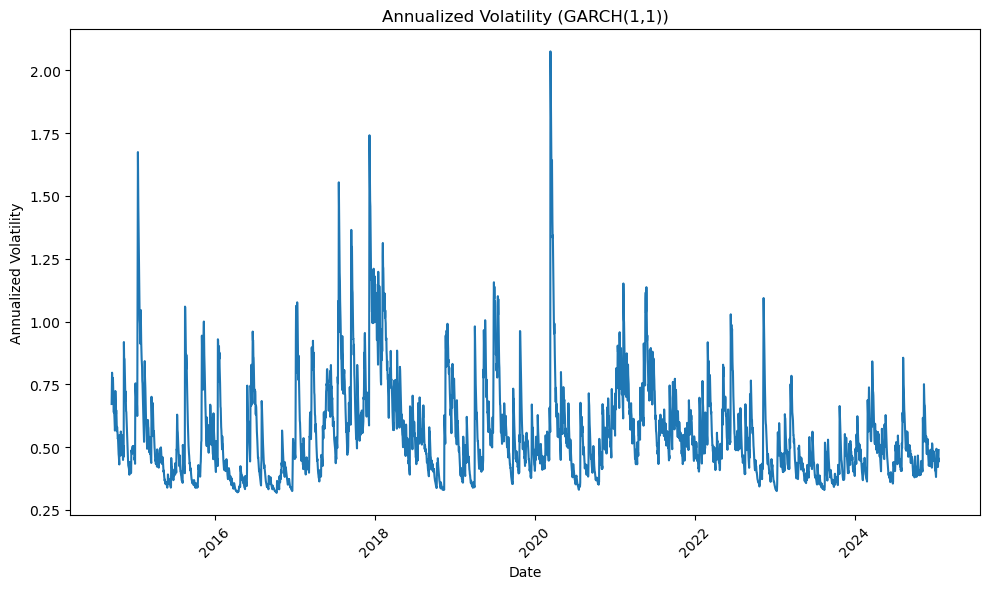

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1194.45
Distribution:                  Normal   AIC:                           2396.90
Method:            Maximum Likelihood   BIC:                           2421.85
                                        No. Observations:                 3776
Date:                Sat, Jan 18 2025   Df Residuals:                     3775
Time:                        16:07:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0204  4.794e-03      4.249  2.152e-05 [1.

In [208]:
# Assuming btc_daily is a 2D numpy array and btc_dates is a corresponding list/array of dates
btc_daily_garch = np.array(btc_daily).flatten()  # Flatten the array to make it 1D
btc_dates = np.array(btc_daily.loc[start_date:end_date].index)  # Replace with your actual dates

# Convert btc_dates to a pandas datetime index
btc_prices = pd.Series(btc_daily_garch, index=pd.to_datetime(btc_dates))

# Step 1: Calculate the daily returns (percentage change) for the specified date range
btc_returns = btc_prices.loc[start_date:end_date].pct_change().dropna()

# Step 2: Rescale the returns to improve convergence (scale by 10)
scaled_returns = btc_returns * 10

# Step 3: Fit the GARCH(1,1) model to the rescaled returns
model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
garch_fit = model.fit()

# Step 4: Extract the volatility (conditional standard deviation)
volatility = garch_fit.conditional_volatility

# Step 5: Rescale the volatility back to the original scale
volatility = volatility / 10

# Step 6: Annualize the volatility (assuming 252 trading days per year)
annualized_volatility = volatility * np.sqrt(252)

# Step 7: Plot the annualized volatility with the date index
plt.figure(figsize=(10, 6))
plt.plot(btc_returns.loc[start_date:end_date].index, annualized_volatility)
plt.title('Annualized Volatility (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

# Optionally, print the model summary
print(garch_fit.summary())

In [210]:
# def obpi_strategy(risky_asset, riskless_rate, floor_fraction, initial_portfolio_value, time_to_maturity):
#     """
#     Implements the OBPI (Option-Based Portfolio Insurance) strategy.

#     Parameters:
#         risky_asset (array-like or pd.Series): Prices of the risky asset (e.g., BTC).
#         riskless_rate (array-like or pd.Series): Annualized risk-free rates (e.g., T-Bill rates in %), same length as risky_asset.
#         floor_fraction (float): Fraction of the initial portfolio value to set as the floor.
#         initial_portfolio_value (float): Initial value of the portfolio.
#         time_to_maturity (float): Time to maturity in years.

#     Returns:
#         pd.DataFrame: DataFrame containing basket values, risky weights, and risk-free weights.
#     """
#     # Convert inputs to NumPy arrays if they are not pandas Series
#     if isinstance(risky_asset, pd.Series):
#         dates = risky_asset.index
#         risky_asset = risky_asset.values
#     else:
#         dates = btc_weekly.loc[start_date:end_date].index

#     if isinstance(riskless_rate, pd.Series):
#         riskless_rate = riskless_rate.values

#     # Ensure inputs have the same length
#     if len(risky_asset) != len(riskless_rate):
#         raise ValueError("The lengths of risky_asset and riskless_rate must be the same.")

#     # Initialize variables
#     basket_value = initial_portfolio_value
#     floor = basket_value * floor_fraction
#     dt = 1 / 52  # Weekly time step in years

#     # Initialize lists to store results
#     risky_weights = []
#     riskless_weights = []
#     basket_values = []

#     # Loop over each time step
#     for i in range(1, len(risky_asset)):
#         # Update remaining time to maturity
#         remaining_ttm = time_to_maturity - i * dt

#         # Update risk-free allocation to ensure the floor is met
#         riskless_allocation = floor / ((1 + riskless_rate[i] / 100) ** remaining_ttm)
#         risky_allocation = max(basket_value - riskless_allocation, 0)

#         # Calculate risky and risk-free weights
#         risky_w = risky_allocation / basket_value
#         riskless_w = 1 - risky_w

#         # Ensure weights are valid
#         risky_w = max(min(risky_w, 1), 0)
#         riskless_w = 1 - risky_w

#         # Calculate returns
#         risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
#         riskless_return = ((1 + riskless_rate[i] / 100) ** (1 / 52)) - 1  # Weekly compounding

#         # Update portfolio value
#         portfolio_return = risky_w * risky_return + riskless_w * riskless_return
#         basket_value = basket_value * (1 + portfolio_return)

#         # Append results
#         risky_weights.append(risky_w)
#         riskless_weights.append(riskless_w)
#         basket_values.append(basket_value)

#     # Create the output DataFrame
#     index = dates[1:] if dates is not None else range(1, len(risky_asset))
#     obpi_df = pd.DataFrame({
#         'Basket Value': basket_values,
#         'Risky Weights': risky_weights,
#         'Risk-Free Weights': riskless_weights
#     }, index=index)

#     return obpi_df


# def run_obpi_for_multiple_params(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity):
#     """
#     Runs the OBPI strategy for different combinations of floor fractions.

#     Parameters:
#         risky_asset (array-like or pd.Series): Prices of the risky asset (e.g., BTC).
#         riskless_rate (array-like or pd.Series): Annualized risk-free rates (e.g., T-Bill rates in %), same length as risky_asset.
#         floor_fractions (list): List of floor fractions to test.
#         initial_portfolio_value (float): Initial value of the portfolio.
#         time_to_maturity (float): Time to maturity in years.

#     Returns:
#         dict: Dictionary containing DataFrames for each floor_fraction.
#     """
#     results = {}

#     for floor_fraction in floor_fractions:
#         # Run the OBPI strategy for the current floor_fraction
#         df = obpi_strategy(risky_asset, riskless_rate, floor_fraction, initial_portfolio_value, time_to_maturity)
#         results[floor_fraction] = df

#     return results

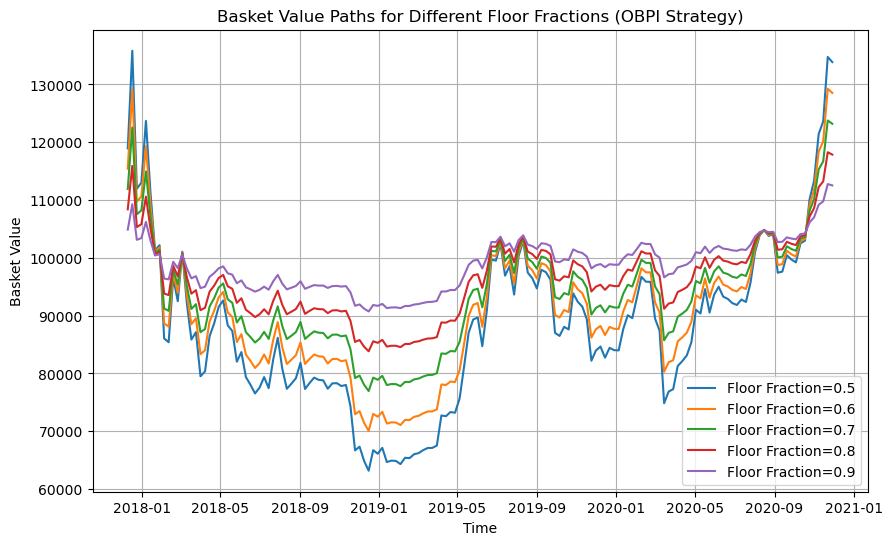

In [375]:
plotted_floors = set()  # To track already plotted floor fractions
plt.figure(figsize=(10, 6))

# Loop through the OBPI results and plot for unique floor fractions
for floor_fraction, df in obpi_results.items():
    # Plot only if the floor fraction hasn't been plotted yet
    if floor_fraction not in plotted_floors:
        plt.plot(df.index, df['Basket Value'], label=f'Floor Fraction={floor_fraction}')
        plotted_floors.add(floor_fraction)  # Mark this floor fraction as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Different Floor Fractions (OBPI Strategy)')
plt.grid(True)
plt.legend()
plt.show()

In [377]:
max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best (multiplier, floor_fraction)

for (floor_fraction), df in obpi_results.items():
    last_basket_value = df['Basket Value'].iloc[-1]
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (floor_fraction)  # Update best parameters

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Floor Fraction = {best_params}")

Maximum Basket Value: [133863.01399875]
Best Parameters: Floor Fraction = 0.5


In [275]:
obpi_results[0.5]['Basket Value']

Date
2014-09-28     [97286.60374030788]
2014-10-05      [90179.4892509843]
2014-10-12     [97456.84186855222]
2014-10-19      [98836.6473961165]
2014-10-26     [94467.90398365042]
                      ...         
2017-12-03    [1482095.1626970193]
2017-12-10    [2004742.3684131124]
2017-12-17    [2470879.6700735884]
2017-12-24     [1811305.297003454]
2017-12-31    [1840484.4294482195]
Freq: W-SUN, Name: Basket Value, Length: 171, dtype: object

In [379]:
basket_values = pd.DataFrame(obpi_results[0.5]['Basket Value'])
basket_values_ret = basket_values.pct_change().dropna().values
basket_values_ret.mean()

array([0.00194885])

In [381]:
risk_free_rate = t_bill_array / 100  # Weekly rate
risk_free_rate = risk_free_rate.flatten()
risk_free_rate = risk_free_rate[:len(basket_values_ret)].mean()

In [383]:
basket_values_ret_ann = basket_values_ret.mean() * 52
basket_values_ret_ann_std = basket_values_ret.std() * np.sqrt(52)
basket_values_ret_ann_sr = (basket_values_ret_ann - risk_free_rate) / basket_values_ret_ann_std

print(f'Avg return annualized: {basket_values_ret_ann}')
print(f'Std annualized: {basket_values_ret_ann_std}')
print(f'SR annualized: {basket_values_ret_ann_sr}')

Avg return annualized: [0.10134005]
Std annualized: [0.34764766]
SR annualized: [0.24896293]


## Comparison of both strategies on historical prices with 60/40 allocation

In [385]:
def simple_allocation_strategy(risky_asset, riskless_rate, allocation_ratio, initial_investment):
    """
    Implements a simple 60/40 allocation strategy where the portfolio is split at the beginning
    and the return is calculated iteratively using a for loop.

    Parameters:
        risky_asset (array-like): Prices of the risky asset (e.g., BTC).
        riskless_rate (array-like): Weekly rates of the risk-free asset (e.g., T-Bill).
        allocation_ratio (float): The ratio of the portfolio to allocate to the risky asset (60% for BTC, 40% for T-Bill).
        initial_investment (float): Initial total portfolio value.

    Returns:
        pd.DataFrame: Portfolio values for each week.
    """
    # Initial allocation
    btc_value = initial_investment * allocation_ratio
    t_bill_value = initial_investment * (1 - allocation_ratio)
    portfolio_values = []

    # Iterate over the time period
    for i in range(1, len(risky_asset)):
        # Calculate BTC return for the current week
        btc_weekly_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
        btc_value *= (1 + btc_weekly_return)

        # Calculate T-Bill return for the current week (rate-based)
        t_bill_weekly_return = riskless_rate[i] / 100 / 52  # Weekly rate adjustment
        t_bill_value *= (1 + t_bill_weekly_return)

        # Store portfolio value
        portfolio_values.append(btc_value + t_bill_value)

    # Convert portfolio values to a DataFrame
    portfolio_df = pd.DataFrame(portfolio_values, columns=["Total Portfolio Value"])

    return portfolio_df

def plot_allocation_strategy(portfolio_df, dates):
    """
    Plots the portfolio values over time.

    Parameters:
        portfolio_df (pd.DataFrame): DataFrame containing the portfolio values.
        dates (pd.DatetimeIndex): Dates corresponding to the portfolio values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates[1:], portfolio_df['Total Portfolio Value'], label='Total Portfolio Value', color='blue')
    plt.title("60/40 Allocation Strategy Portfolio Value")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()


In [387]:
btc_array = np.array(btc_weekly.loc[start_date:end_date])  # BTC weekly data
t_bill_array = np.array(t_bill_weekly.loc[start_date:end_date])  # T-Bill weekly rates

allocation_ratio = 0.60  # 60% for BTC, 40% for T-Bill
initial_investment = 100000  # Example initial portfolio value

final_portfolio_value = simple_allocation_strategy(btc_array, t_bill_array, allocation_ratio, initial_investment)

final_portfolio_value

,Total Portfolio Value
0,121905.620880
1,141444.065372
2,113820.538297
3,115052.976801
4,127363.276115
...,...
151,114582.019545
152,123815.746331
153,126338.734346
154,139132.895674


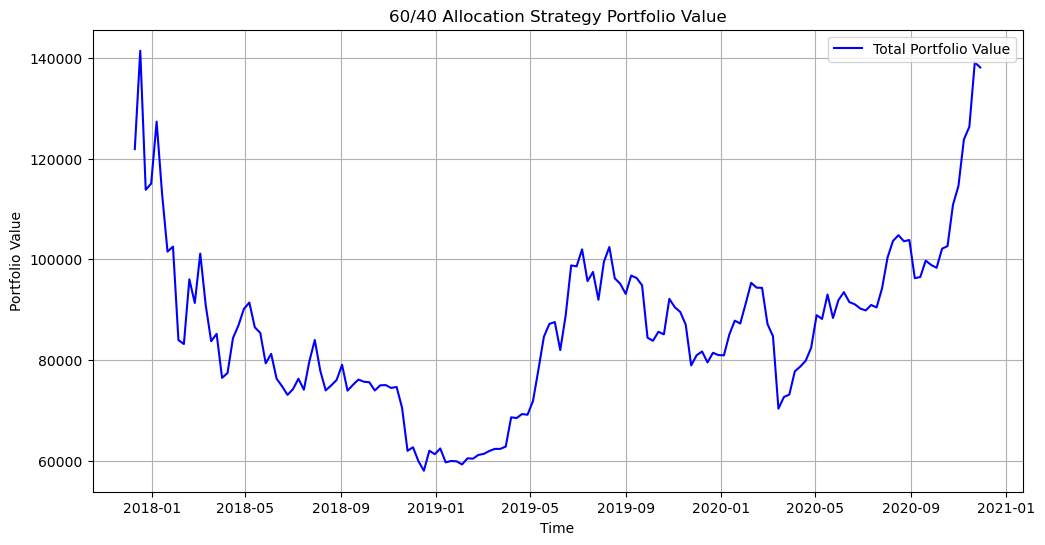

In [389]:
# Assuming `btc_prices` and `t_bill_rates` are pandas Series with a DateTime index
initial_investment = 100000  # Example initial investment
allocation_ratio = 0.6  # 60% allocation to BTC
portfolio_df = simple_allocation_strategy(btc_array, t_bill_array, allocation_ratio, initial_investment)

# Plot the results
plot_allocation_strategy(portfolio_df, btc_weekly[start_date:end_date].index)

In [391]:
basket_values_ret = final_portfolio_value.pct_change().dropna()
basket_values_ret.mean()

Total Portfolio Value    0.002393
dtype: float64

In [393]:
risk_free_rate = t_bill_array / 100  # Weekly rate
risk_free_rate = risk_free_rate.flatten()
risk_free_rate = risk_free_rate[:len(basket_values_ret)].mean()

In [395]:
basket_values_ret_ann = basket_values_ret.mean() * 52
basket_values_ret_ann_std = basket_values_ret.std() * np.sqrt(52)
basket_values_ret_ann_sr = (basket_values_ret_ann - risk_free_rate) / basket_values_ret_ann_std

print(f'Avg return annualized: {basket_values_ret_ann}')
print(f'Std annualized: {basket_values_ret_ann_std}')
print(f'SR annualized: {basket_values_ret_ann_sr}')

Avg return annualized: Total Portfolio Value    0.124457
dtype: float64
Std annualized: Total Portfolio Value    0.403067
dtype: float64
SR annualized: Total Portfolio Value    0.272084
dtype: float64


In [282]:
final_portfolio_value['Total Portfolio Value'].iloc[-1]

138113.3702983722

## CPPI on simulations of future BTC prices 

In [474]:
def calculate_mean_and_volatility(btc_daily):
    # Compute simple returns for mean
    simple_returns = btc_daily.pct_change().dropna()
    
    # Compute log returns for volatility
    log_returns = np.log(btc_daily / btc_daily.shift(1)).dropna()
    
    # Calculate mean using simple returns
    mean = simple_returns.mean()
    
    # Calculate volatility using log returns
    volatility = log_returns.std()
    
    return mean, volatility

In [476]:
mean, volatility = calculate_mean_and_volatility(btc_daily)

print(f"Mean (Simple Returns): {mean}")
print(f"Volatility (Log Returns): {volatility}")

Mean (Simple Returns): Ticker
BTC-USD    0.002077
dtype: float64
Volatility (Log Returns): Ticker
BTC-USD    0.036433
dtype: float64


In [478]:
annualized_mean = np.array(mean * 252)
annualized_volatility = np.array(volatility * np.sqrt(252))


print(f"Annualized Mean (Simple Returns): {annualized_mean}")
print(f"Annualized Volatility (Log Returns): {annualized_volatility}")

Annualized Mean (Simple Returns): [0.52332202]
Annualized Volatility (Log Returns): [0.57836294]


In [490]:
t_bill_weekly.mean()

Ticker
^IRX    1.712043
dtype: float64

In [341]:
def simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations):
    """
    Simulates BTC price evolution using Geometric Brownian Motion (GBM).

    Parameters:
        initial_price (float): Current BTC price.
        mu (float): Drift (mean return).
        sigma (float): Volatility (standard deviation of log returns).
        time_horizon (float): Time horizon in years.
        steps_per_year (int): Number of time steps per year (e.g., 252 for daily steps).
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        np.ndarray: Simulated price paths of shape (steps, simulations).
    """
    # Derived parameters
    dt = 1 / steps_per_year  # Time step
    total_steps = int(time_horizon * steps_per_year)  # Total number of steps
    
    # Initialize price paths
    price_paths = np.zeros((total_steps + 1, num_simulations))
    price_paths[0] = initial_price  # Set initial price for all simulations
    
    # Simulate GBM paths
    for t in range(1, total_steps + 1):
        # Generate random normal values
        z = np.random.standard_normal(num_simulations)
        
        # GBM formula
        price_paths[t] = price_paths[t - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
        )
    
    return price_paths

In [343]:
# Example usage
initial_price = btc_daily.iloc[-1]  # Current BTC price
mu = annualized_mean  # Drift (annualized mean return)
sigma = annualized_volatility  # Volatility (annualized standard deviation)
time_horizon = 1  # 1 years
steps_per_year = 52  # Weekly steps
num_simulations = 1000  # Number of Monte Carlo simulations

price_paths = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

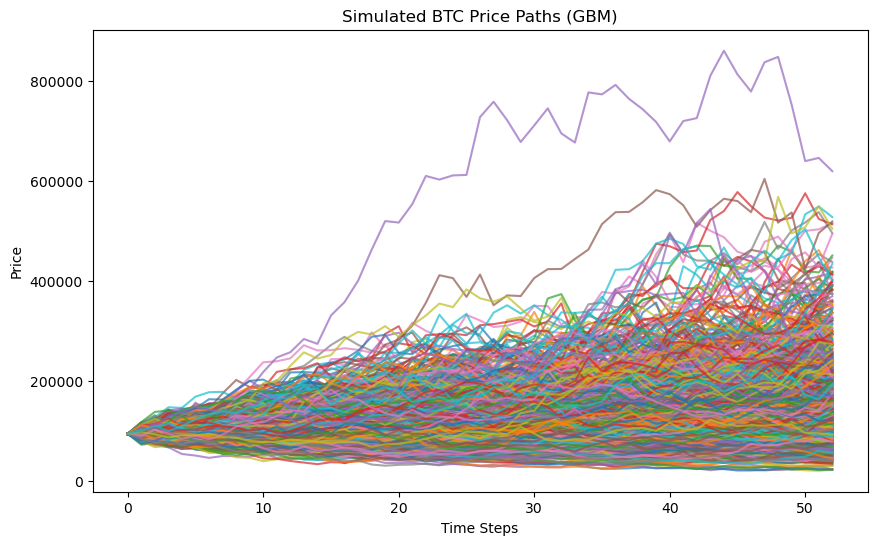

In [345]:
# Plot some simulated paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

In [347]:
price_paths[-1].mean()

160906.38356010924

In [492]:
def cppi_strategy_simulation(risky_asset, riskless_rate, multiplier, floor_fraction, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple paths.

    Parameters:
        risky_asset (2D array-like): Prices of the risky asset (rows: time steps, columns: paths).
        riskless_rate (float): Annualized risk-free rate (e.g., 2.5%).
        multiplier (float): Multiplier for the cushion.
        floor_fraction (float): Fraction of the initial portfolio value to set as the floor.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing:
            - 'Basket Values': 2D array of basket values (same shape as risky_asset).
            - 'Risky Weights': 2D array of risky weights (same shape as risky_asset).
            - 'Risk-Free Weights': 2D array of risk-free weights (same shape as risky_asset).
    """
    # Convert inputs to NumPy arrays
    risky_asset = np.asarray(risky_asset)

    # Dimensions of the risky asset
    num_steps, num_paths = risky_asset.shape

    # Initialize results
    basket_values = np.zeros_like(risky_asset)
    risky_weights = np.zeros_like(risky_asset)
    riskless_weights = np.zeros_like(risky_asset)

    # Convert annualized riskless rate to weekly rate
    weekly_riskless_rate = (1 + riskless_rate / 100) ** (1 / 52) - 1

    # Loop over each path
    for path_idx in range(num_paths):
        # Initialize variables for the current path
        basket_value = initial_portfolio_value
        floor = basket_value * floor_fraction

        # Loop over each time step
        for t in range(1, num_steps):
            # Calculate the cushion as a percentage of the portfolio
            cushion = max(basket_value - floor, 0) / basket_value

            # Calculate the risky allocation based on the CPPI formula
            risky_w = multiplier * cushion
            risky_w = min(risky_w, 1)  # Cap the risky allocation to 100%
            risky_w = max(risky_w, 0)  # Ensure the risky allocation is non-negative

            # Calculate the risk-free allocation
            riskless_w = 1 - risky_w

            # Calculate returns
            risky_return = (risky_asset[t, path_idx] - risky_asset[t - 1, path_idx]) / risky_asset[t - 1, path_idx]
            riskless_return = weekly_riskless_rate

            # Update portfolio value
            portfolio_return = risky_w * risky_return + riskless_w * riskless_return
            basket_value = basket_value * (1 + portfolio_return)

            # Store results
            basket_values[t, path_idx] = basket_value
            risky_weights[t, path_idx] = risky_w
            riskless_weights[t, path_idx] = riskless_w

        # Set initial basket value for the first time step
        basket_values[0, path_idx] = initial_portfolio_value

    # Combine results into a dictionary
    results = {
        'Basket Values': basket_values,
        'Risky Weights': risky_weights,
        'Risk-Free Weights': riskless_weights
    }

    return results

In [494]:
# Calculate the CPPI strategy
cppi_results = cppi_strategy_simulation(price_paths, 2, multiplier, floor_fraction, initial_portfolio_value)

cppi_results

{'Basket Values': array([[100000.        , 100000.        , 100000.        , ...,
         100000.        , 100000.        , 100000.        ],
        [ 97769.57874481, 103540.64022136, 111171.00801899, ...,
          93433.06206433, 101785.27415803, 103346.17046929],
        [ 91974.30704445,  97043.47954739, 108127.11742245, ...,
          91760.99824809,  99091.69655326, 111719.20655123],
        ...,
        [ 90342.35129016,  90572.99706844, 266781.83142881, ...,
          90339.66367895,  90153.7446481 , 169119.38874299],
        [ 90440.164929  ,  90558.62226569, 272305.87709642, ...,
          90388.20276005,  90183.69284735, 159766.77941613],
        [ 90858.38092224,  91130.11978346, 248374.05983808, ...,
          90212.13282086,  90190.66000606, 189591.80242766]]),
 'Risky Weights': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.6       , 0.6       , 0.6       , ..., 0.6       , 0.6       ,
         0.6       ],
   

In [496]:
def cppi_strategy_simulation(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple paths
    with different combinations of multipliers and floor fractions.

    Parameters:
        risky_asset (2D array-like): Prices of the risky asset (rows: time steps, columns: paths).
        riskless_rate (float): Annualized risk-free rate (e.g., 2.5%).
        multipliers (list): List of multipliers for the cushion.
        floor_fractions (list): List of floor fractions to set as the floor.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination:
            - 'Basket Values': 2D array of basket values (same shape as risky_asset).
            - 'Risky Weights': 2D array of risky weights (same shape as risky_asset).
            - 'Risk-Free Weights': 2D array of risk-free weights (same shape as risky_asset).
    """
    # Convert inputs to NumPy arrays
    risky_asset = np.asarray(risky_asset)

    # Dimensions of the risky asset
    num_steps, num_paths = risky_asset.shape

    # Convert annualized riskless rate to weekly rate
    weekly_riskless_rate = (1 + riskless_rate / 100) ** (1 / 52) - 1

    # Initialize a dictionary to store results for each (multiplier, floor_fraction) combination
    all_results = {}

    # Loop over each combination of multiplier and floor_fraction
    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize results for this combination
            basket_values = np.zeros_like(risky_asset)
            risky_weights = np.zeros_like(risky_asset)
            riskless_weights = np.zeros_like(risky_asset)

            # Loop over each path
            for path_idx in range(num_paths):
                # Initialize variables for the current path
                basket_value = initial_portfolio_value
                floor = basket_value * floor_fraction

                # Loop over each time step
                for t in range(1, num_steps):
                    # Calculate the cushion as a percentage of the portfolio
                    cushion = max(basket_value - floor, 0) / basket_value

                    # Calculate the risky allocation based on the CPPI formula
                    risky_w = multiplier * cushion
                    risky_w = min(risky_w, 1)  # Cap the risky allocation to 100%
                    risky_w = max(risky_w, 0)  # Ensure the risky allocation is non-negative

                    # Calculate the risk-free allocation
                    riskless_w = 1 - risky_w

                    # Calculate returns
                    risky_return = (risky_asset[t, path_idx] - risky_asset[t - 1, path_idx]) / risky_asset[t - 1, path_idx]
                    riskless_return = weekly_riskless_rate

                    # Update portfolio value
                    portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                    basket_value = basket_value * (1 + portfolio_return)

                    # Store results
                    basket_values[t, path_idx] = basket_value
                    risky_weights[t, path_idx] = risky_w
                    riskless_weights[t, path_idx] = riskless_w

                # Set initial basket value for the first time step
                basket_values[0, path_idx] = initial_portfolio_value

            # Store the results for this (multiplier, floor_fraction) combination
            all_results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Risk-Free Weights': riskless_weights
            }

    return all_results

In [498]:
# Calculate the CPPI strategy
cppi_results = cppi_strategy_simulation(price_paths, 2, multipliers, floor_fractions, initial_portfolio_value)

cppi_results

{(1,
  0.5): {'Basket Values': array([[100000.        , 100000.        , 100000.        , ...,
          100000.        , 100000.        , 100000.        ],
         [ 98147.66382529, 102956.88172241, 109315.52155377, ...,
           94533.89992489, 101494.07666964, 102794.82359568],
         [ 92161.08734891,  98735.36964319, 107710.4920362 , ...,
           90877.94593695,  99542.96826953, 108328.37193129],
         ...,
         [ 89774.88233874, 108680.80787911, 193969.53405954, ...,
           74686.15041917, 101789.0940631 , 142121.75461217],
         [ 91036.78478702, 107888.01426531, 196969.64480007, ...,
           74885.74774035, 101581.36445056, 137046.29889819],
         [ 97034.60590456, 117203.74741092, 184072.1460055 , ...,
           72665.27339313, 100338.51604247, 153315.0161736 ]]), 'Risky Weights': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,

In [500]:
max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best (multiplier, floor_fraction)

for (multiplier, floor_fraction), result in cppi_results.items():
    # Get the basket values for the current combination
    basket_values = result['Basket Values']
    
    # Extract the last basket value for each path (final time step)
    last_basket_value = basket_values[-1, :].max()  # Get the maximum final basket value across all paths
    
    # Update if we find a new maximum basket value
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (multiplier, floor_fraction)  # Update best parameters

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Multiplier = {best_params[0]}, Floor Fraction = {best_params[1]}")

Maximum Basket Value: 652625.8204716255
Best Parameters: Multiplier = 2, Floor Fraction = 0.5


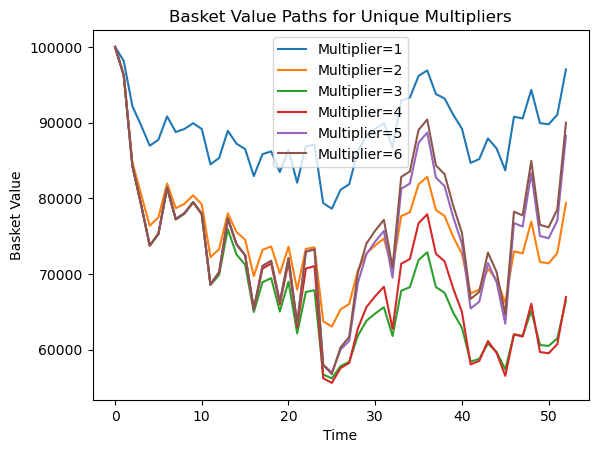

In [502]:
plotted_multipliers = set()  # To track already plotted multipliers

for (multiplier, floor_fraction), result in cppi_results.items():
    # Get the basket values for the current combination
    basket_values = result['Basket Values']
    
    # Plot only if the multiplier hasn't been plotted yet
    if multiplier not in plotted_multipliers:
        # Plot the basket values for all paths at each time step
        plt.plot(range(basket_values.shape[0]), basket_values[:, 0], label=f'Multiplier={multiplier}')  # Plot first path as an example
        plotted_multipliers.add(multiplier)  # Mark this multiplier as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Unique Multipliers')
plt.legend()
plt.show()

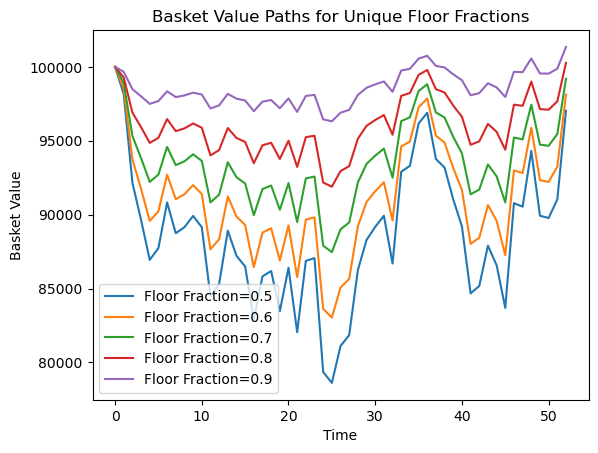

In [504]:
plotted_floors = set()  # To track already plotted floor fractions

for (multiplier, floor_fraction), result in cppi_results.items():
    # Get the basket values for the current combination
    basket_values = result['Basket Values']
    
    # Plot only if the floor fraction hasn't been plotted yet
    if floor_fraction not in plotted_floors:
        # Plot the basket values for all paths at each time step
        plt.plot(range(basket_values.shape[0]), basket_values[:, 0], label=f'Floor Fraction={floor_fraction}')  # Plot first path as an example
        plotted_floors.add(floor_fraction)  # Mark this floor fraction as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Unique Floor Fractions')
plt.legend()
plt.show()

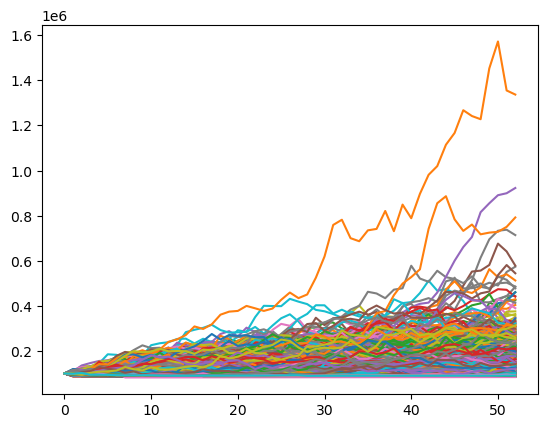

137579.3894779751

In [411]:
plt.plot(cppi_results['Basket Values'])
plt.show()
cppi_results['Basket Values'][-1].mean()

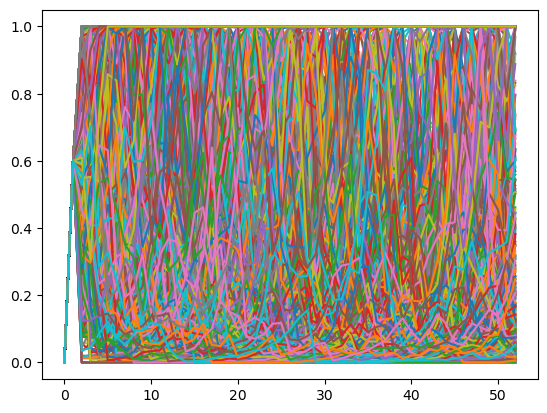

0.46796928760224

In [437]:
plt.plot(cppi_results['Risky Weights'])
plt.show()
cppi_results['Risky Weights'].mean()

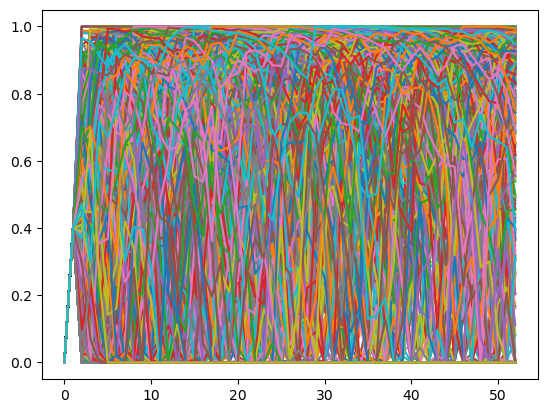

0.5131627878694581

In [433]:
plt.plot(cppi_results['Risk-Free Weights'])
plt.show()
cppi_results['Risk-Free Weights'].mean()

In [449]:
# Assuming 'cppi_results['Basket Values']' is a 2D numpy array
basket_values = cppi_results['Basket Values']

# Flatten the 2D array to 1D (treating all simulations as one series)
basket_values_flat = basket_values.flatten()

# Convert to a pandas Series
basket_values_series = pd.Series(basket_values_flat)

# Calculate daily returns from basket values
returns = basket_values_series.pct_change().dropna()

# 1. Average Return
average_return = returns.mean()

# 2. Standard Deviation
std_deviation = returns.std()

# 3. Sharpe Ratio (assuming a risk-free rate of 0%)
sharpe_ratio = average_return / std_deviation

# 4. Sortino Ratio (downside deviation instead of total standard deviation)
downside_returns = returns[returns < 0]
downside_deviation = downside_returns.std()
sortino_ratio = average_return / downside_deviation

# 5. VaR 5% (Value at Risk at 5% level)
VaR_5 = np.percentile(returns, 5)

# 6. Expected Shortfall 5% (average of returns below the 5% percentile)
expected_shortfall_5 = returns[returns <= VaR_5].mean()

# 7. Skewness
skewness = skew(returns)

# Display results
print(f"Average Return: {average_return:.4f}")
print(f"Standard Deviation: {std_deviation:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"VaR 5%: {VaR_5:.4f}")
print(f"Expected Shortfall 5%: {expected_shortfall_5:.4f}")
print(f"Skewness: {skewness:.4f}")

Average Return: 0.0988
Standard Deviation: 0.5770
Sharpe Ratio: 0.1713
Sortino Ratio: 0.4893
VaR 5%: -0.5189
Expected Shortfall 5%: -0.6163
Skewness: 5.0538


## OBPI on simulations of future BTC prices

In [532]:
def obpi_strategy_simulation(risky_asset, riskless_rate, floor_fraction, initial_portfolio_value, time_to_maturity):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple paths.

    Parameters:
        risky_asset (2D array-like): Prices of the risky asset (rows: time steps, columns: paths).
        riskless_rate (float): Annualized risk-free rate (e.g., T-Bill rate in %).
        floor_fraction (float): Fraction of the initial portfolio value to set as the floor.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.

    Returns:
        dict: A dictionary containing:
            - 'Basket Values': 2D array of basket values (same shape as risky_asset).
            - 'Risky Weights': 2D array of risky weights (same shape as risky_asset).
            - 'Risk-Free Weights': 2D array of risk-free weights (same shape as risky_asset).
    """
    # Convert risky_asset to a NumPy array
    risky_asset = np.asarray(risky_asset)

    # Ensure risky_asset is a 2D array
    num_steps, num_paths = risky_asset.shape

    # Calculate weekly riskless rate from annualized rate
    weekly_riskless_rate = (1 + riskless_rate / 100) ** (1 / 52) - 1

    # Initialize result arrays
    basket_values = np.zeros_like(risky_asset)
    risky_weights = np.zeros_like(risky_asset)
    riskless_weights = np.zeros_like(risky_asset)

    # Time step in years
    dt = time_to_maturity / (num_steps - 1)

    # Loop over each path
    for path_idx in range(num_paths):
        # Initialize basket value for each path
        basket_value = initial_portfolio_value
        floor = basket_value * floor_fraction

        # Set initial basket value
        basket_values[0, path_idx] = basket_value

        # Loop over each time step
        for t in range(1, num_steps):
            # Update remaining time to maturity
            remaining_ttm = time_to_maturity - (t - 1) * dt

            # Update risk-free allocation to ensure the floor is met
            riskless_allocation = floor / ((1 + weekly_riskless_rate) ** remaining_ttm)
            risky_allocation = max(basket_value - riskless_allocation, 0)

            # Calculate risky and risk-free weights
            risky_w = risky_allocation / basket_value
            riskless_w = 1 - risky_w

            # Ensure weights are valid
            risky_w = max(min(risky_w, 1), 0)
            riskless_w = 1 - risky_w

            # Calculate returns
            risky_return = (risky_asset[t, path_idx] - risky_asset[t - 1, path_idx]) / risky_asset[t - 1, path_idx]
            riskless_return = weekly_riskless_rate

            # Update portfolio value
            portfolio_return = risky_w * risky_return + riskless_w * riskless_return
            basket_value = basket_value * (1 + portfolio_return)

            # Store results for the current time step and path
            basket_values[t, path_idx] = basket_value
            risky_weights[t, path_idx] = risky_w
            riskless_weights[t, path_idx] = riskless_w

    # Return results as a dictionary
    results = {
        'Basket Values': basket_values,
        'Risky Weights': risky_weights,
        'Risk-Free Weights': riskless_weights
    }

    return results

In [461]:
results = obpi_strategy_simulation(
    risky_asset=price_paths,
    riskless_rate=2.5,
    floor_fraction=0.9,
    initial_portfolio_value=100000,
    time_to_maturity=1  # 1 year to maturity
)

In [463]:
results

{'Basket Values': array([[100000.        , 100000.        , 100000.        , ...,
         100000.        , 100000.        , 100000.        ],
        [100318.38554487, 100723.4326976 ,  99584.80219261, ...,
         101840.79002493, 100070.44773829,  99818.5665196 ],
        [101013.67072943, 101623.37129614,  99284.42801634, ...,
         101014.12451503,  99224.31794304, 100473.30885161],
        ...,
        [116646.50120325, 108356.57104114, 119642.68296033, ...,
         126599.52728884, 124737.70027606,  97787.16439225],
        [116802.13230401, 109799.70664101, 125224.79921455, ...,
         125957.71058983, 123390.77275296,  99053.18029163],
        [114605.75606972, 112074.7932196 , 128096.12852619, ...,
         124506.38714593, 122458.84798149,  99134.80177934]]),
 'Risky Weights': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10042727, 0.10042727, 0.10042727, ..., 0.10042727, 0.10042727,
         0.10042727],
   

In [542]:
def obpi_strategy_simulation_loop(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (2D array-like): Prices of the risky asset (rows: time steps, columns: paths).
        riskless_rate (float): Annualized risk-free rate (e.g., T-Bill rate in %).
        floor_fractions (list of float): List of fractions of the initial portfolio value to set as the floor.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.

    Returns:
        dict: A dictionary where keys are floor fractions and values are DataFrames containing:
            - 'Basket Value': Series of basket values for each time step.
            - 'Risky Weight': Series of risky weights for each time step.
            - 'Risk-Free Weight': Series of risk-free weights for each time step.
    """
    # Convert risky_asset to a NumPy array
    risky_asset = np.asarray(risky_asset)

    # Ensure risky_asset is a 2D array
    num_steps, num_paths = risky_asset.shape

    # Calculate weekly riskless rate from annualized rate
    weekly_riskless_rate = (1 + riskless_rate / 100) ** (1 / 52) - 1

    # Time step in years
    dt = time_to_maturity / (num_steps - 1)

    # Dictionary to store results for each floor fraction
    results_dict = {}

    # Loop over each floor fraction
    for floor_fraction in floor_fractions:
        # Initialize result arrays
        basket_values = np.zeros_like(risky_asset)
        risky_weights = np.zeros_like(risky_asset)
        riskless_weights = np.zeros_like(risky_asset)

        # Loop over each path
        for path_idx in range(num_paths):
            # Initialize basket value for each path
            basket_value = initial_portfolio_value
            floor = basket_value * floor_fraction

            # Set initial basket value
            basket_values[0, path_idx] = basket_value

            # Loop over each time step
            for t in range(1, num_steps):
                # Update remaining time to maturity
                remaining_ttm = time_to_maturity - (t - 1) * dt

                # Update risk-free allocation to ensure the floor is met
                riskless_allocation = floor / ((1 + weekly_riskless_rate) ** remaining_ttm)
                risky_allocation = max(basket_value - riskless_allocation, 0)

                # Calculate risky and risk-free weights
                risky_w = risky_allocation / basket_value
                riskless_w = 1 - risky_w

                # Ensure weights are valid
                risky_w = max(min(risky_w, 1), 0)
                riskless_w = 1 - risky_w

                # Calculate returns
                risky_return = (risky_asset[t, path_idx] - risky_asset[t - 1, path_idx]) / risky_asset[t - 1, path_idx]
                riskless_return = weekly_riskless_rate

                # Update portfolio value
                portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                basket_value = basket_value * (1 + portfolio_return)

                # Store results for the current time step and path
                basket_values[t, path_idx] = basket_value
                risky_weights[t, path_idx] = risky_w
                riskless_weights[t, path_idx] = riskless_w

        # Convert the results for the current floor fraction into a DataFrame
        df = pd.DataFrame({
            'Basket Value': basket_values[:, 0],  # Example for the first path
            'Risky Weight': risky_weights[:, 0],
            'Risk-Free Weight': riskless_weights[:, 0],
        }, index=np.arange(num_steps))

        # Store the DataFrame in the results dictionary
        results_dict[floor_fraction] = df

    return results_dict

In [548]:
obpi_results = obpi_strategy_simulation_loop(
    price_paths,
    2.5,
    floor_fractions,
    initial_portfolio_value,
    1  # 1 year to maturity
)

In [550]:
obpi_results

{0.5:      Basket Value  Risky Weight  Risk-Free Weight
 0   100000.000000      0.000000          0.000000
 1    98151.468043      0.500237          0.499763
 2    92166.206014      0.490820          0.509180
 3    89639.954383      0.457749          0.542251
 4    86949.303775      0.442463          0.557537
 5    87756.506595      0.425204          0.574796
 6    90846.103095      0.430486          0.569514
 7    88771.910047      0.449850          0.550150
 8    89183.402715      0.436990          0.563010
 9    89952.753240      0.439583          0.560417
 10   89191.405907      0.444371          0.555629
 11   84511.432371      0.439623          0.560377
 12   85359.657692      0.408586          0.591414
 13   88969.200435      0.414457          0.585543
 14   87272.586593      0.438208          0.561792
 15   86554.316075      0.427281          0.572719
 16   82979.865333      0.422523          0.577477
 17   85893.114776      0.397642          0.602358
 18   86260.230996      0.

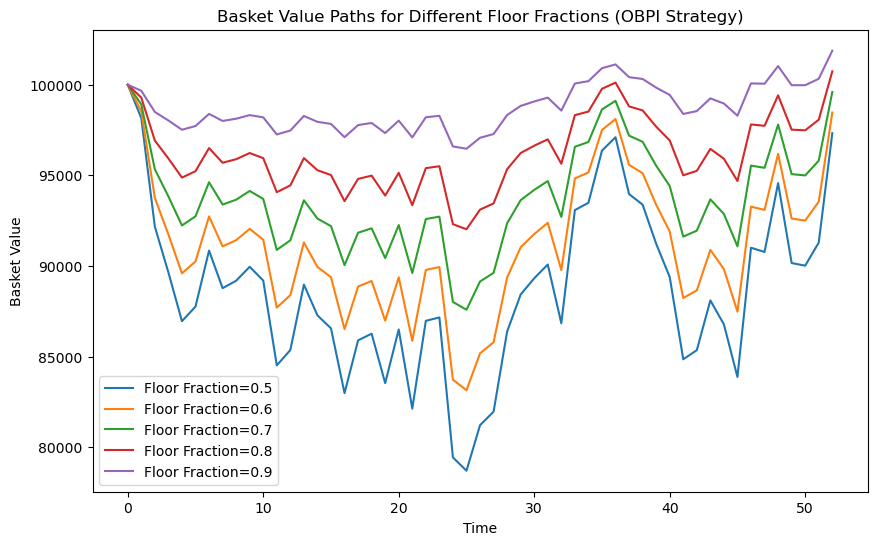

In [552]:
plotted_floors = set()  # To track already plotted floor fractions
plt.figure(figsize=(10, 6))

# Loop through the OBPI results and plot for unique floor fractions
for floor_fraction, df in obpi_results.items():
    # Plot only if the floor fraction hasn't been plotted yet
    if floor_fraction not in plotted_floors:
        plt.plot(df.index, df['Basket Value'], label=f'Floor Fraction={floor_fraction}')
        plotted_floors.add(floor_fraction)  # Mark this floor fraction as plotted

plt.xlabel('Time')
plt.ylabel('Basket Value')
plt.title('Basket Value Paths for Different Floor Fractions (OBPI Strategy)')
plt.legend()
plt.show()

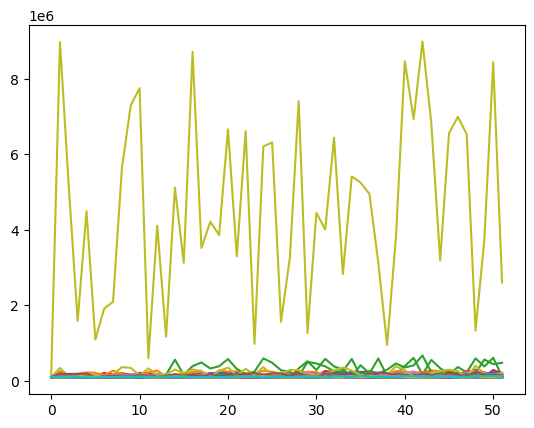

146659.16960084575

In [540]:
plt.plot(results['Basket Values'])
plt.show()
results['Basket Values'][-1].mean()

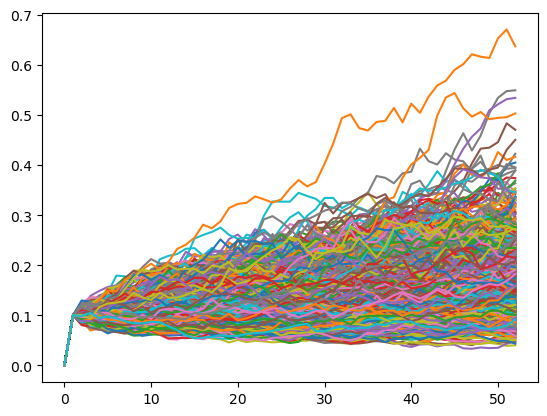

0.1321927013264321

In [467]:
plt.plot(results['Risky Weights'])
plt.show()
results['Risky Weights'].mean()

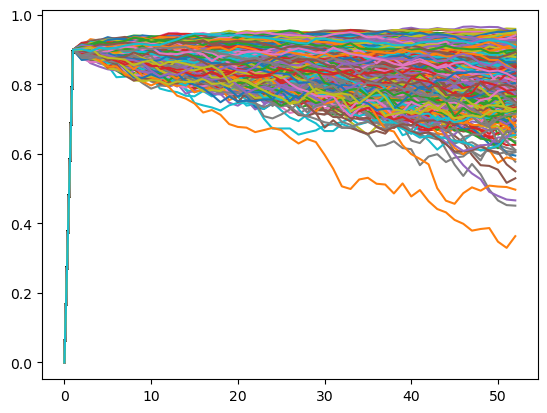

0.848939374145266

In [469]:
plt.plot(results['Risk-Free Weights'])
plt.show()
results['Risk-Free Weights'].mean()

In [471]:
# Assuming 'cppi_results['Basket Values']' is a 2D numpy array
basket_values = results['Basket Values']

# Flatten the 2D array to 1D (treating all simulations as one series)
basket_values_flat = basket_values.flatten()

# Convert to a pandas Series
basket_values_series = pd.Series(basket_values_flat)

# Calculate daily returns from basket values
returns = basket_values_series.pct_change().dropna()

# 1. Average Return
average_return = returns.mean()

# 2. Standard Deviation
std_deviation = returns.std()

# 3. Sharpe Ratio (assuming a risk-free rate of 0%)
sharpe_ratio = average_return / std_deviation

# 4. Sortino Ratio (downside deviation instead of total standard deviation)
downside_returns = returns[returns < 0]
downside_deviation = downside_returns.std()
sortino_ratio = average_return / downside_deviation

# 5. VaR 5% (Value at Risk at 5% level)
VaR_5 = np.percentile(returns, 5)

# 6. Expected Shortfall 5% (average of returns below the 5% percentile)
expected_shortfall_5 = returns[returns <= VaR_5].mean()

# 7. Skewness
skewness = skew(returns)

# Display results
print(f"Average Return: {average_return:.4f}")
print(f"Standard Deviation: {std_deviation:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"VaR 5%: {VaR_5:.4f}")
print(f"Expected Shortfall 5%: {expected_shortfall_5:.4f}")
print(f"Skewness: {skewness:.4f}")

Average Return: 0.0036
Standard Deviation: 0.0861
Sharpe Ratio: 0.0414
Sortino Ratio: 0.0661
VaR 5%: -0.1245
Expected Shortfall 5%: -0.1764
Skewness: 1.4745
